In [1]:
import torch
import numpy as np
from spin import create_J_matrix, SpinConfiguration
from modeling import IsingEnergyModel
import matplotlib.pyplot as plt

### Simple model from previous notebook

In [4]:
class IsingSimpleFlowModel(torch.nn.Module):
    def __init__(self, N, n_hidden=256):
        super().__init__()
        
        self.N = N
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2 * self.N**2, n_hidden),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(n_hidden, 2 * self.N**2))
        
    def forward(self, state):
        mask = torch.cat([state[:,:N**2] + state[:,N**2:]]*2, dim=-1)
        probs = self.net(state).exp() * (1 - mask)
        return probs
    
    def make_choice(self, state):
        probs = self(state)
        choice = torch.distributions.categorical.Categorical(probs=probs).sample()
        new_state = state.clone()
        new_state[torch.arange(new_state.shape[0], dtype=torch.int64), choice] = 1
        return new_state

### Training

In [5]:
def create_empty_state(N):
    return torch.zeros(2*(N**2), dtype=torch.float32,requires_grad=True)

def create_input_batch(N, batch_size):
    return torch.cat([create_empty_state(N).reshape(1,-1)] * batch_size, dim=0)  

In [6]:
# In this training methodology, we have to loop on the parent states,
# which is not efficient
def get_parent_states_and_actions(batch):
    parents_states, parent_actions = [], []
    
    for state in batch:
        parents, actions = [], []
        chosen_spins = torch.where(state==1)
        for index in chosen_spins[0]:
            tmp_state = state.clone()
            tmp_state[index] = 0
            parents.append(tmp_state)
            actions.append(index)
        parents_states.append(torch.stack(parents))
        parent_actions.append(torch.stack(actions))
    parents_states = torch.stack(parents_states)
    parent_actions = torch.stack(parent_actions)
    return parents_states, parent_actions

In [12]:
N = 3
batch_size = 1
J = create_J_matrix(N, sigma=2)
model = IsingSimpleFlowModel(N=N)
energy_model = IsingEnergyModel(J=J)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
def choose_trajectory_and_get_metrics(model, batch):
    N = model.N
    
    loss = 0
    for step in range(1, N**2 + 1):
        new_batch = model.make_choice(batch)
        parent_states, parent_actions = get_parent_states_and_actions(new_batch)
        
        parents_flow_in = []
        for ps, pa in zip(parent_states, parent_actions):
            parents_flow_in.append(model(ps)[torch.arange(len(ps)), pa].sum())
        parents_flow_in = torch.stack(parents_flow_in)
        
        if step < N**2:
            reward = 0
            child_flow_out = model(new_batch).sum(dim=1)
        elif step == N**2:
            # Get the energy as a reward.
            # Without TB, exp(-energy) gives too high values so I added
            # 10 * log() as a way to stabilize training.
            # There is no physical meaning to this choice.
            reward = 10 * torch.log(energy_model.get_reward(new_batch))
            child_flow_out = 0
            
        flow_mismatch = (parents_flow_in - child_flow_out - reward)
        loss += flow_mismatch ** 2
        batch = new_batch
    
    batch_loss = loss.mean()
    return batch, batch_loss, reward

In [14]:
def validation_step(model, val_batch_size):
    model.eval()
    N = model.N
    batch = create_input_batch(N=N, batch_size=val_batch_size)
    _, loss, reward = choose_trajectory_and_get_metrics(model, batch)
    return loss.item(), reward.item()

In [15]:
MAX_TRAJECTORIES = 40000
val_interval = 1000
val_batch_size = 100
val_patience, gamma = 10, 0.2
n_traj, n_batches = 0, 0
train_losses, train_rewards = [], []
val_rewards, val_losses = [], []
best_loss, best_reward = np.inf, 0
val_counter = 0

while n_traj < MAX_TRAJECTORIES:
    
    if n_batches%val_interval==0:
        val_loss, val_reward = validation_step(model, 100)
        val_rewards.append(val_reward)
        val_losses.append(val_loss)
        print("--n_traj: ", n_traj)
        print(f"---- Val loss: {val_loss} --- Val reward: {val_reward}")
        
        if ((val_loss < best_loss) or (val_reward > best_reward)):
            val_counter = 0
            if val_loss < best_loss:
                best_loss = val_loss
            if val_reward > best_reward:
                best_reward = val_reward
        else:
            val_counter += 1
        if val_counter >= val_patience:
            for p in optimizer.param_groups:
                p["lr"] *= gamma
            val_counter = 0
    
    n_batches += 1

    model.train()
    batch = create_input_batch(N=N, batch_size=batch_size)
    n_traj += batch_size
    
    _, loss, reward = choose_trajectory_and_get_metrics(model, batch)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

--n_traj:  0
---- Val loss: 162008.59375 --- Val reward: 410.98614501953125
--n_traj:  1000
---- Val loss: 488809.625 --- Val reward: 749.4444580078125
--n_traj:  2000
---- Val loss: 254146.875 --- Val reward: 754.6573486328125
--n_traj:  3000
---- Val loss: 228557.921875 --- Val reward: 755.5535278320312
--n_traj:  4000
---- Val loss: 218370.8125 --- Val reward: 750.910400390625
--n_traj:  5000
---- Val loss: 219241.625 --- Val reward: 752.9583740234375
--n_traj:  6000
---- Val loss: 178491.28125 --- Val reward: 754.3399047851562
--n_traj:  7000
---- Val loss: 192431.859375 --- Val reward: 752.188720703125
--n_traj:  8000
---- Val loss: 208580.203125 --- Val reward: 751.3549194335938
--n_traj:  9000
---- Val loss: 199516.046875 --- Val reward: 750.910400390625
--n_traj:  10000
---- Val loss: 173014.046875 --- Val reward: 753.3220825195312
--n_traj:  11000
---- Val loss: 163885.671875 --- Val reward: 753.3220825195312
--n_traj:  12000
---- Val loss: 180537.078125 --- Val reward: 750.91

In [16]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

200


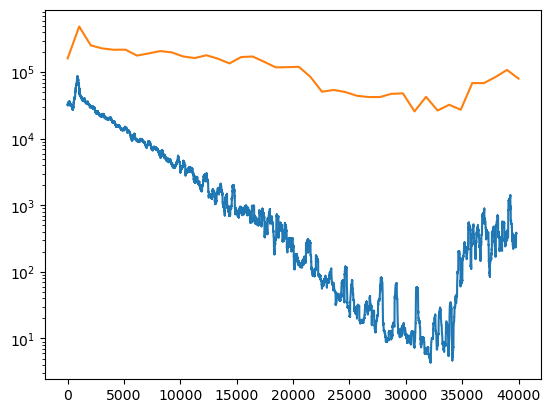

In [33]:
n_average = int(MAX_TRAJECTORIES/batch_size/200)
print(n_average)

averaged_tloss = moving_average(train_losses, n=n_average)
#averaged_vloss = moving_average(val_losses, n=n_av)

ax = plt.gca()
ax.plot(np.linspace(0, len(averaged_tloss), len(averaged_tloss)), averaged_tloss)
ax.plot(np.linspace(0, len(val_losses) * val_interval, len(val_losses)), val_losses)
#ax.set_ylim([0, None])
ax.set_yscale("log")
plt.show()

In [34]:
def spin_to_state(spin):
    N = spin.values.shape[0]
    state = torch.zeros((2*(N**2)))
    state[:N**2][torch.where(spin.values.flatten()==1)] = 1
    state[N**2:][torch.where(spin.values.flatten()==-1)] = 1
    return state

def state_to_spin(state):
    N = int(np.sqrt(state.shape[0]/2))
    values = torch.zeros(N**2, dtype=torch.float32)
    values[torch.where(state[:N**2]==1)] = 1
    values[torch.where(state[N**2:]==1)] = -1
    spin = SpinConfiguration(N, values.reshape(N, N))
    return spin

tensor(9.8510e+32, grad_fn=<SumBackward0>)


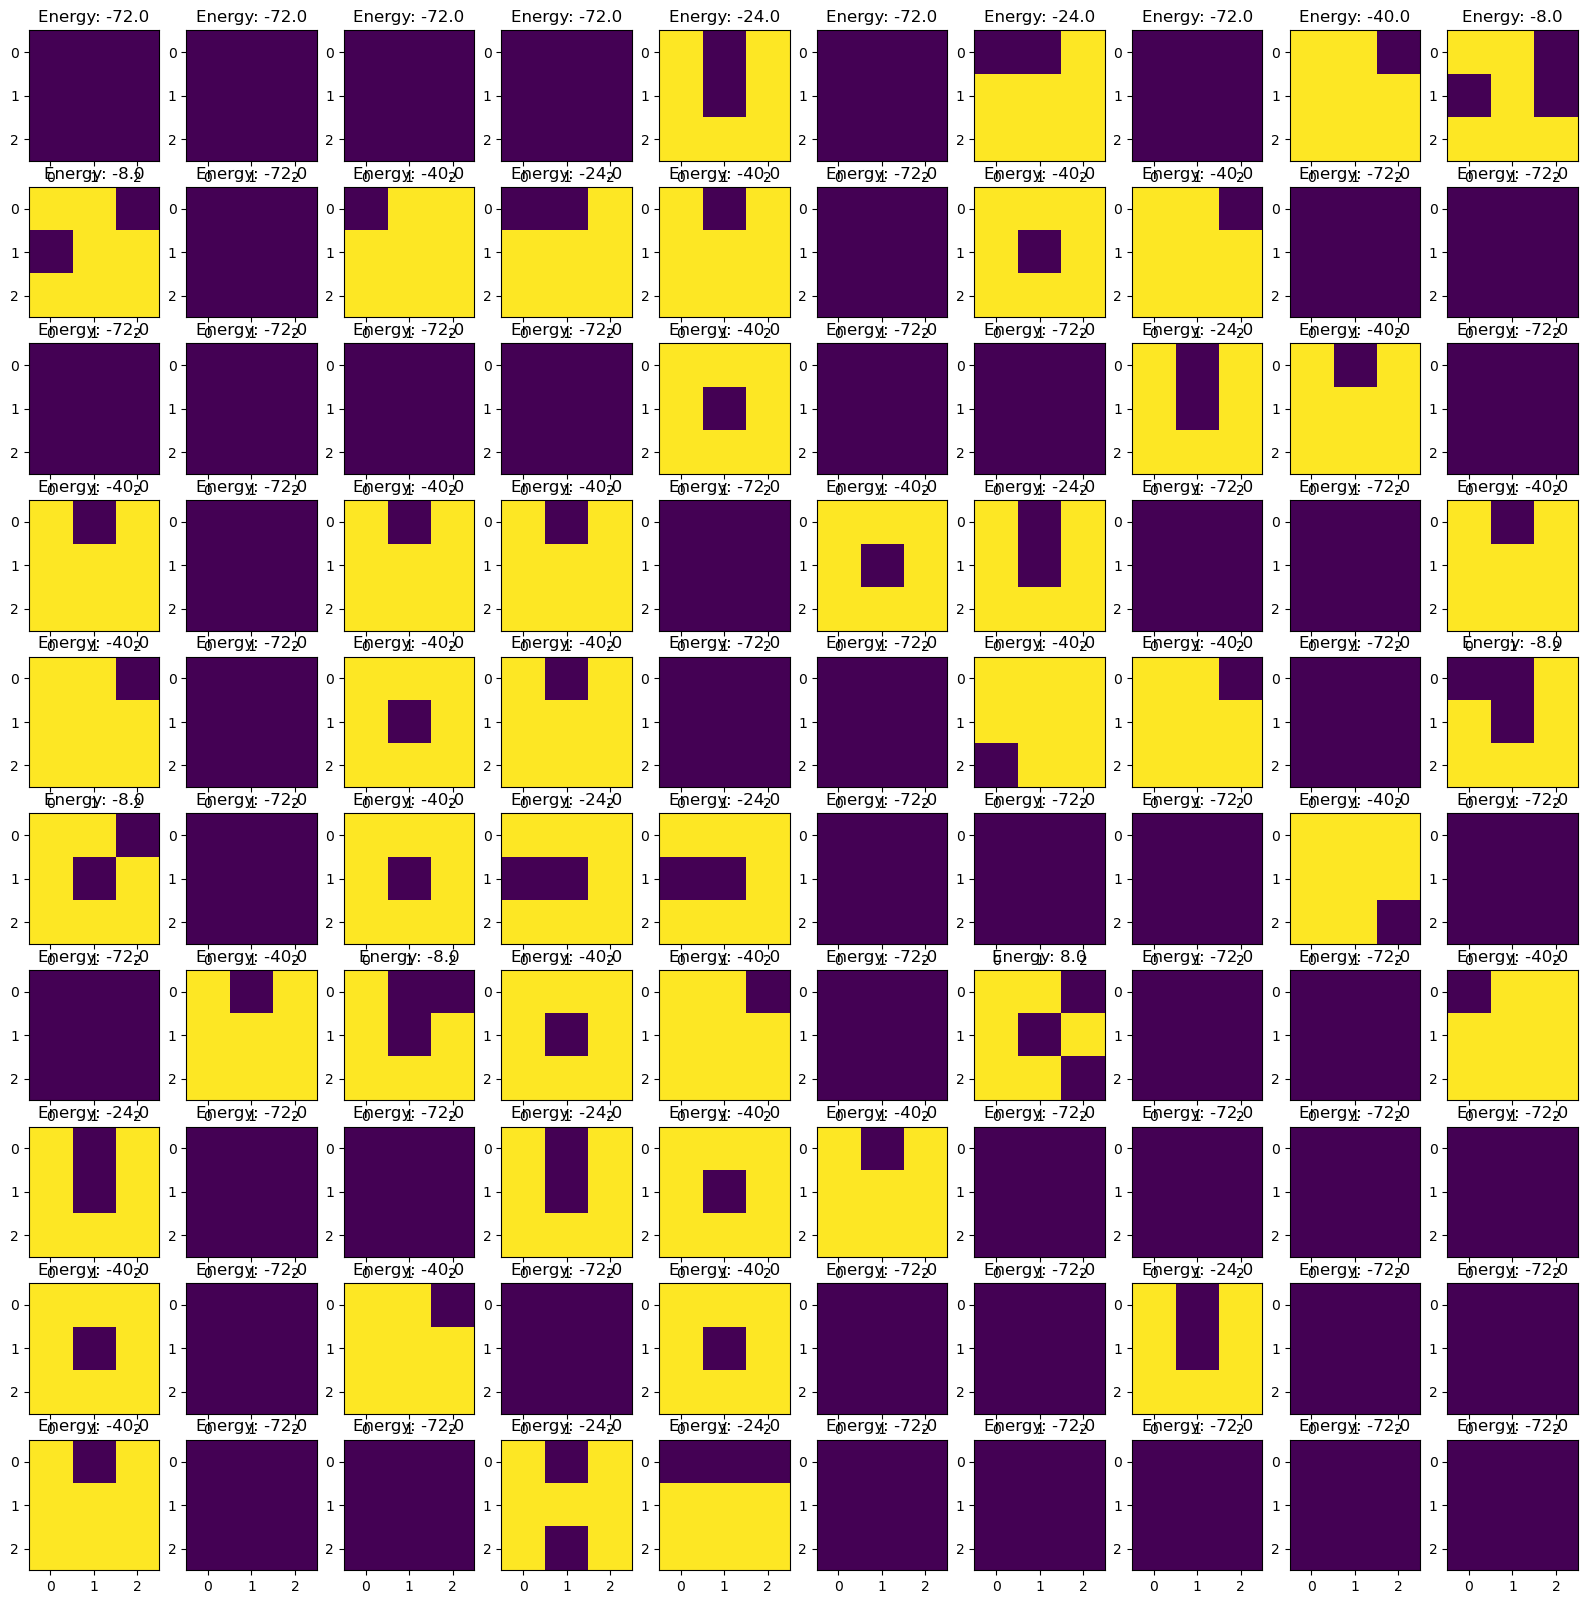

In [35]:
state = create_input_batch(N=N, batch_size=100)

for _ in range(N**2):
    state = model.make_choice(state)
print(energy_model.get_reward(state))
    
spins = [state_to_spin(s) for s in state]
energies = [sp.get_energy(J) for sp in spins]

fig, axs = plt.subplots(figsize=(20, 20), ncols=10, nrows=10)
for i, sp in enumerate(spins):
    axs[i//10][i%10].imshow(sp.values)
    axs[i//10][i%10].set_title(f"Energy: {energies[i]}")

#### Percentage of structures with negative energy

In [36]:
torch.sum(torch.tensor([e < 0 for e in energies]).float())

tensor(99.)

In [41]:
random_model = IsingSimpleFlowModel(N=N)

state = create_input_batch(N=N, batch_size=1000)

for _ in range(N**2):
    state = random_model.make_choice(state)
    
spins = [state_to_spin(s) for s in state]
energies = [sp.get_energy(J) for sp in spins]

#### Percentage of structures with negative energy from a random model

In [43]:
torch.sum(torch.tensor([e < 0 for e in energies]).float())/1000

tensor(0.5240)